# cell2home - create reference and compute homing scores

In [1]:
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import rcParams

import scipy.sparse
import mudata
import muon as mu

import cell2home as c2h

%config InlineBackend.figure_format = 'retina'

In [2]:
# Create a list to hold the pairs
pairs = []
# Iterate through the dictionary to create pairs
for key, values in c2h.markers.items():
    for value in values:
        pairs.append((key, value))

# Create a DataFrame from the pairs
interactions = pd.DataFrame(pairs, columns=['target', 'source'])
interactions

target   source
0    CCR1     CCL3
1    CCR1     CCL5
2    CCR1     CCL7
3    CCR1     CCL8
4    CCR1    CCL14
..    ...      ...
89  ITGB7      FN1
90  ITGB7  MADCAM1
91  ITGB7    VCAM1
92  ITGB7     CDH1
93  ITGAE     CDH1

[94 rows x 2 columns]

In [3]:
# Load reference data (these are the cells expressing ligands that attract the migrating cells) - here T cells from cross-tissue immune atlas (Dominguez-Conde et al. Science 2022)
adata = sc.read_h5ad('/lustre/scratch126/cellgen/teichmann/od5/datasets/CountAdded_PIP_T_object_for_cellxgene.h5ad')
adata.X = adata.layers["counts"]
del adata.layers["counts"]

In [4]:
adata

AnnData object with n_obs × n_vars = 216611 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'

/software/conda/users/od5/cell2home/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


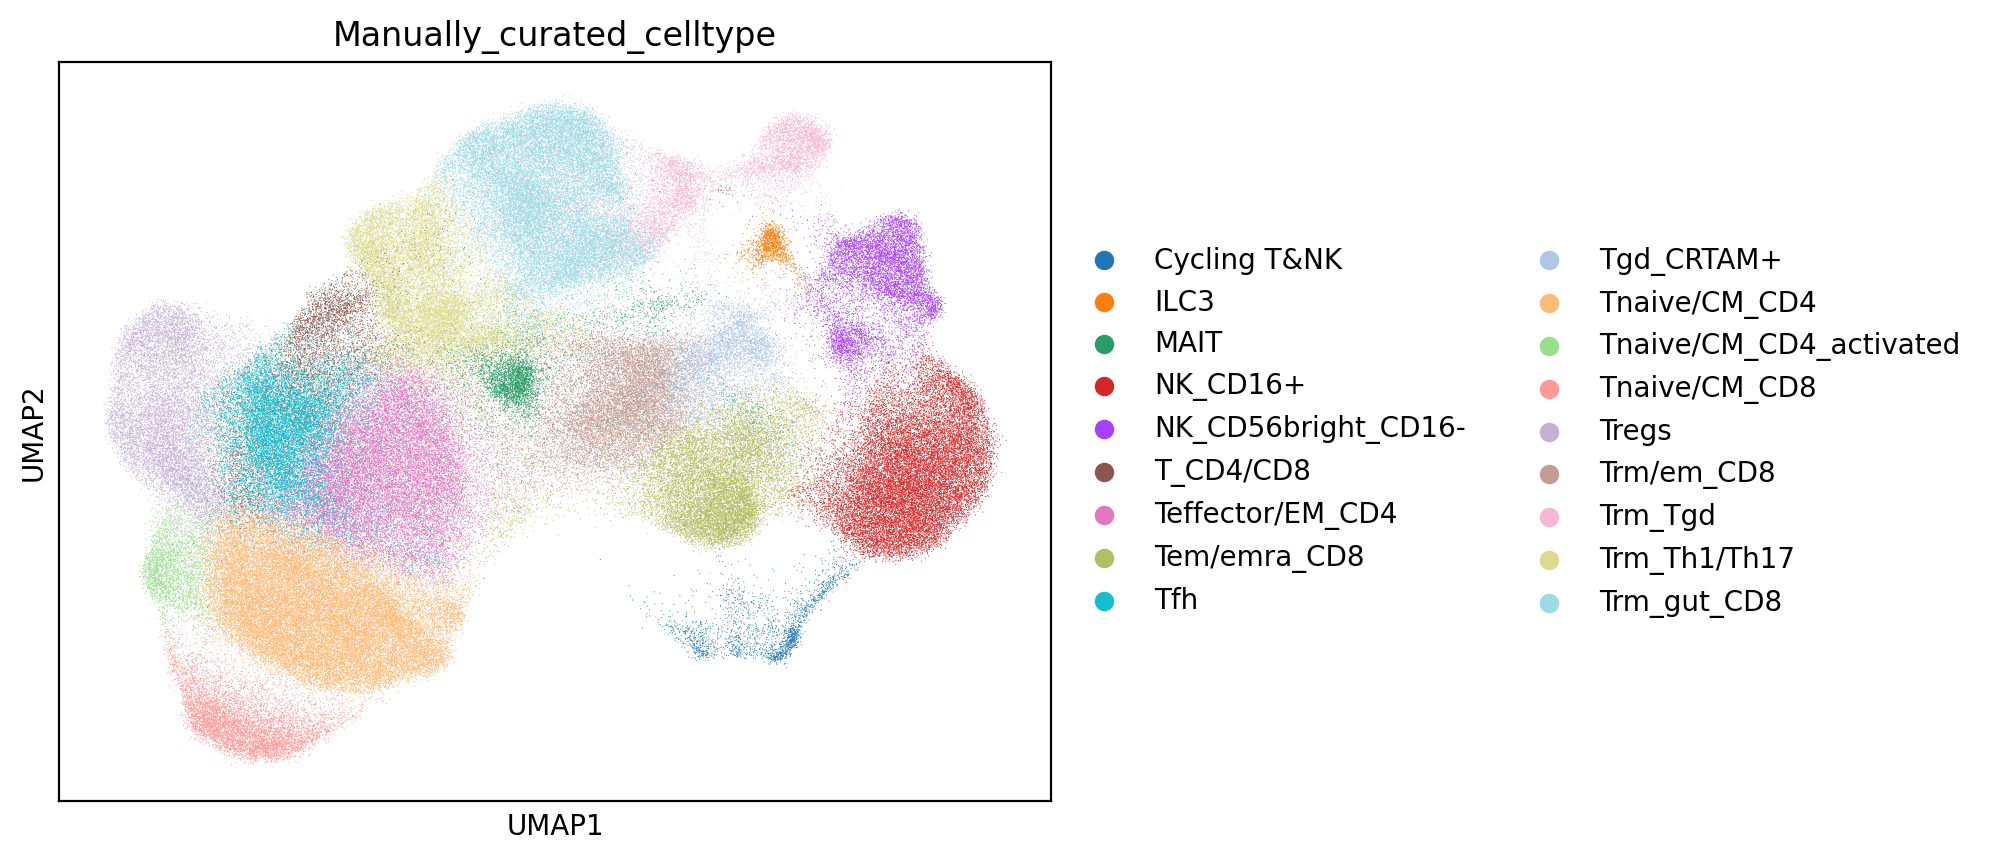

In [5]:
sc.pl.umap(adata, color='Manually_curated_celltype')

In [6]:
# Construct signatures from selected cell types
signatures = c2h.construct_signatures(adata, 'Manually_curated_celltype', interactions)
signatures

population source  expression target
0     Cycling T&NK   CCL3    0.881343   CCR1
1     Cycling T&NK   CCL3    0.881343   CCR3
2     Cycling T&NK   CCL3    0.881343   CCR5
3             ILC3   CCL3   -0.758298   CCR1
4             ILC3   CCL3   -0.758298   CCR3
...            ...    ...         ...    ...
1687       Trm_Tgd   CDH1    2.585478  ITGAE
1688  Trm_Th1/Th17   CDH1    0.798664  ITGB7
1689  Trm_Th1/Th17   CDH1    0.798664  ITGAE
1690   Trm_gut_CD8   CDH1    0.491016  ITGB7
1691   Trm_gut_CD8   CDH1    0.491016  ITGAE

[1692 rows x 4 columns]

In [7]:
# Load query data (these are the migrating cells expressing chemokine receptors) - here cross-tissue immune atlas (Dominguez-Conde et al. Science 2022)
adata = sc.read_h5ad('/lustre/scratch126/cellgen/teichmann/od5/datasets/myeloid.h5ad')

In [8]:
# Compute migration scores for each cell in query data against the generated reference
mdata = c2h.compute_cell_scores(adata, signatures)

/software/conda/users/od5/cell2home/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/software/conda/users/od5/cell2home/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
# Collapse scores at the level of population and target=receptor (this is done for later analysis aggregating signals at the receptor level)
c2h.collapse_scores(mdata, ["population", "target"], collapse_key="cell2home_target_affinity")

In [10]:
# Collapse scores at the level of population (this is the final result)
c2h.collapse_scores(mdata, "population", score_key="cell2home_target_affinity", collapse_key="cell2home_affinity")

In [11]:
mdata.update()
mdata

MuData object with n_obs × n_vars = 51552 × 38779
  4 modalities
    rna:	51552 x 36601
      obs:	'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype'
      obsm:	'X_umap'
    cell_scores:	51552 x 1692
      obs:	'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype'
      var:	'population', 'source', 'target'
      obsm:	'X_umap'
    cell2home_target_affinity:	51552 x 468
      obs:	'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype'
      var:	'population', 'target'
    cell2home_affinity:	51552 x 18
      obs:	'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype'
      var:	'population'

In [12]:
# List populations for plotting
populations = mdata['cell2home_affinity'].var_names.unique().tolist()

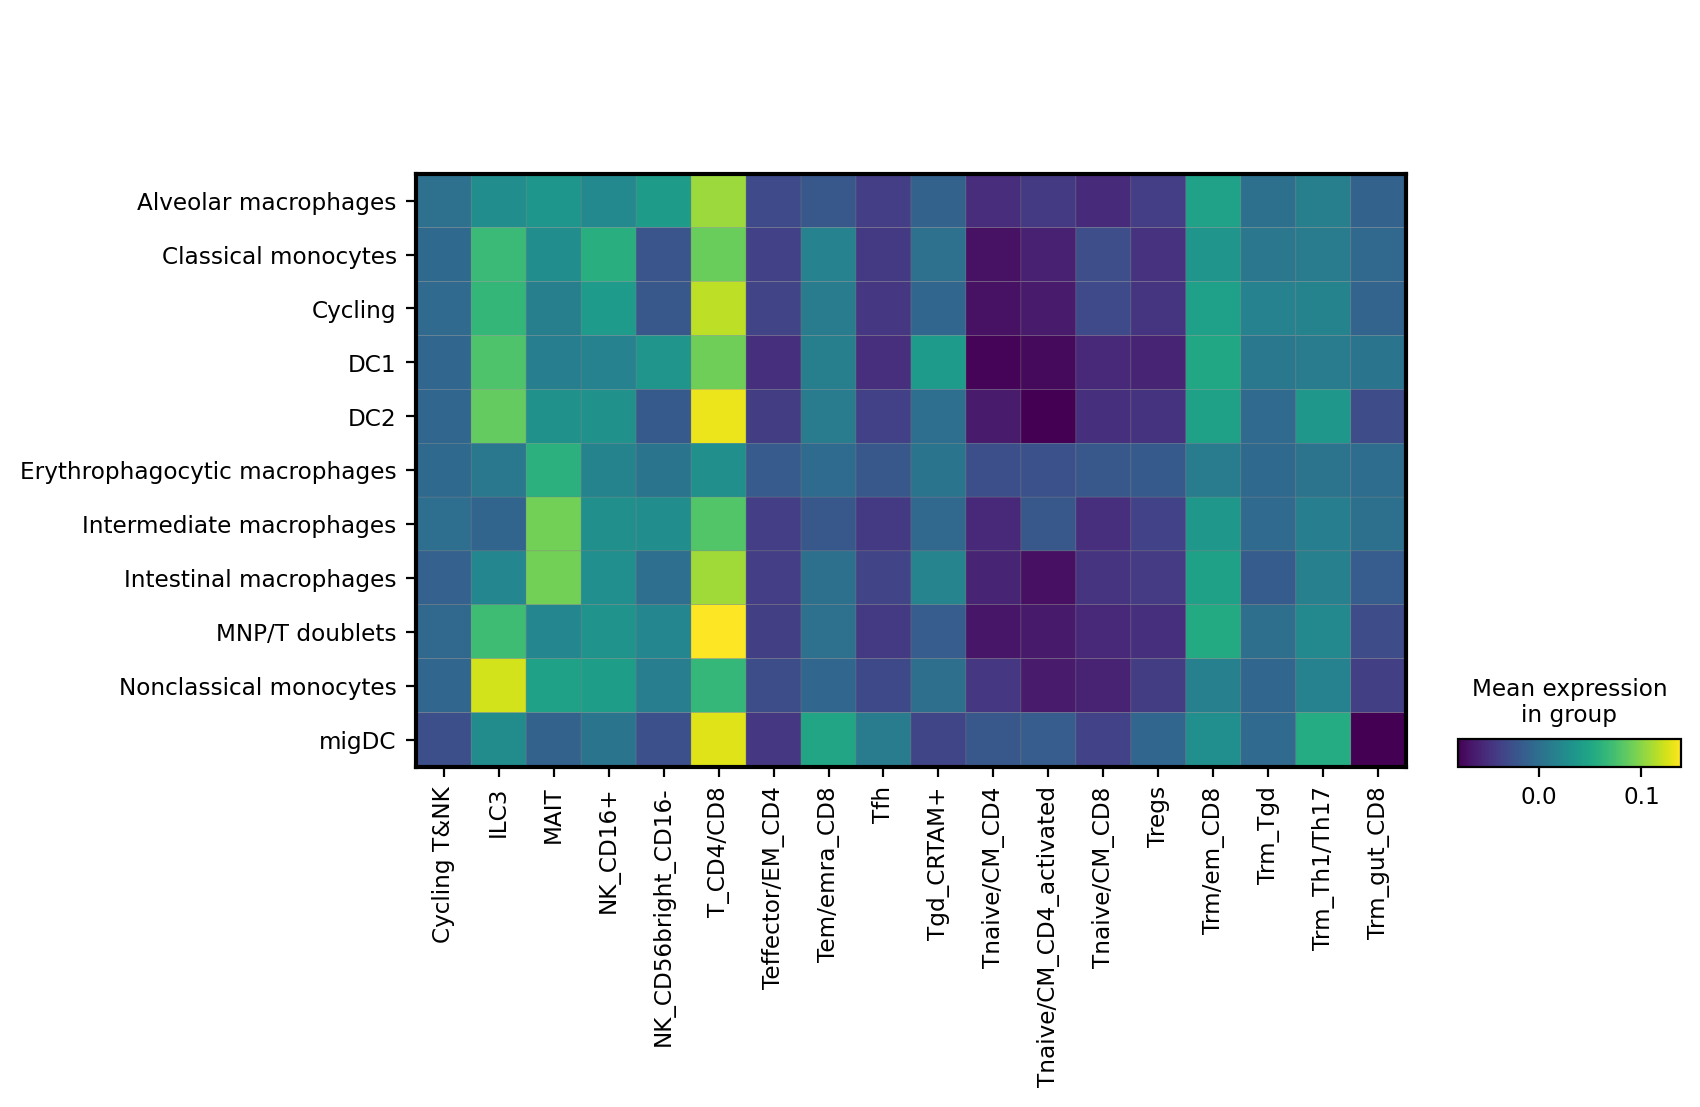

In [13]:
# Visualise scores as heatmap
sc.pl.matrixplot(mdata['cell2home_affinity'], var_names=populations, groupby='Manually_curated_celltype')

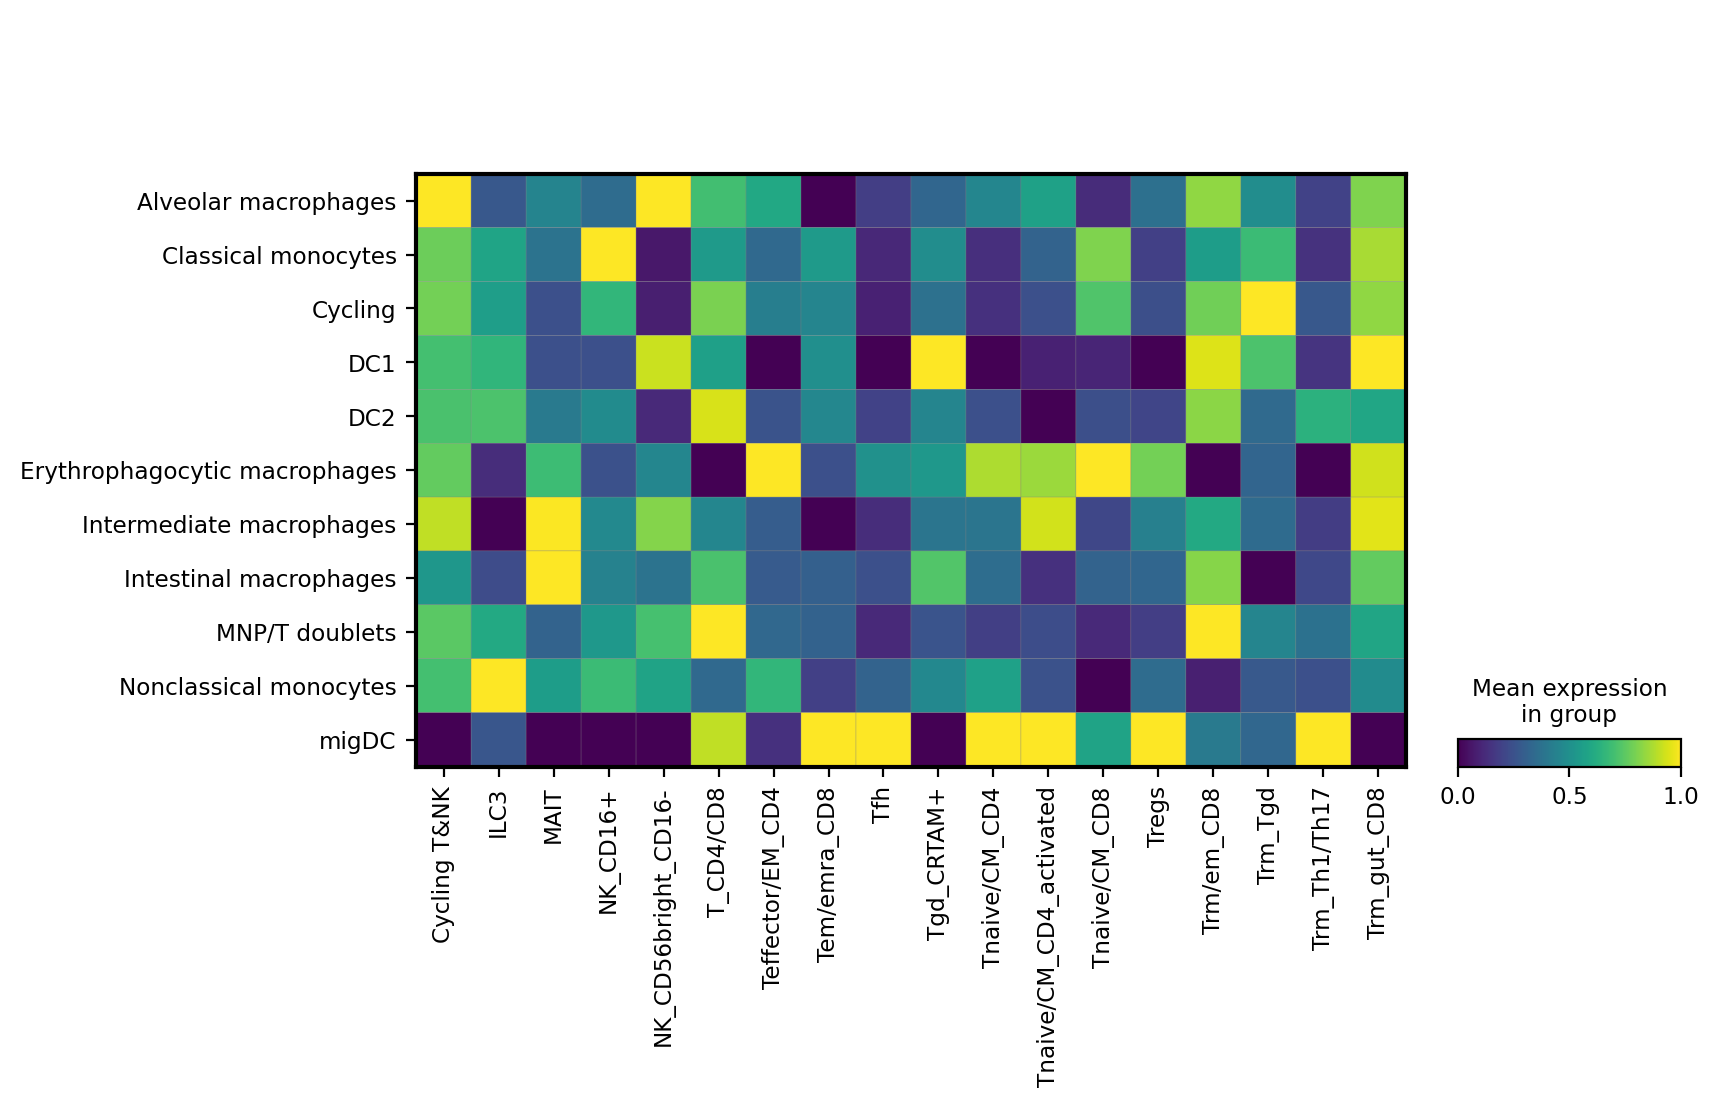

In [14]:
# Scaling often works better
sc.pl.matrixplot(mdata['cell2home_affinity'], var_names=populations, groupby='Manually_curated_celltype', standard_scale='var')

Here colour intensity shows predicted affinity of myeloid cells on the y axis towards various T and NK cell subsets on x axis.

/software/conda/users/od5/cell2home/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


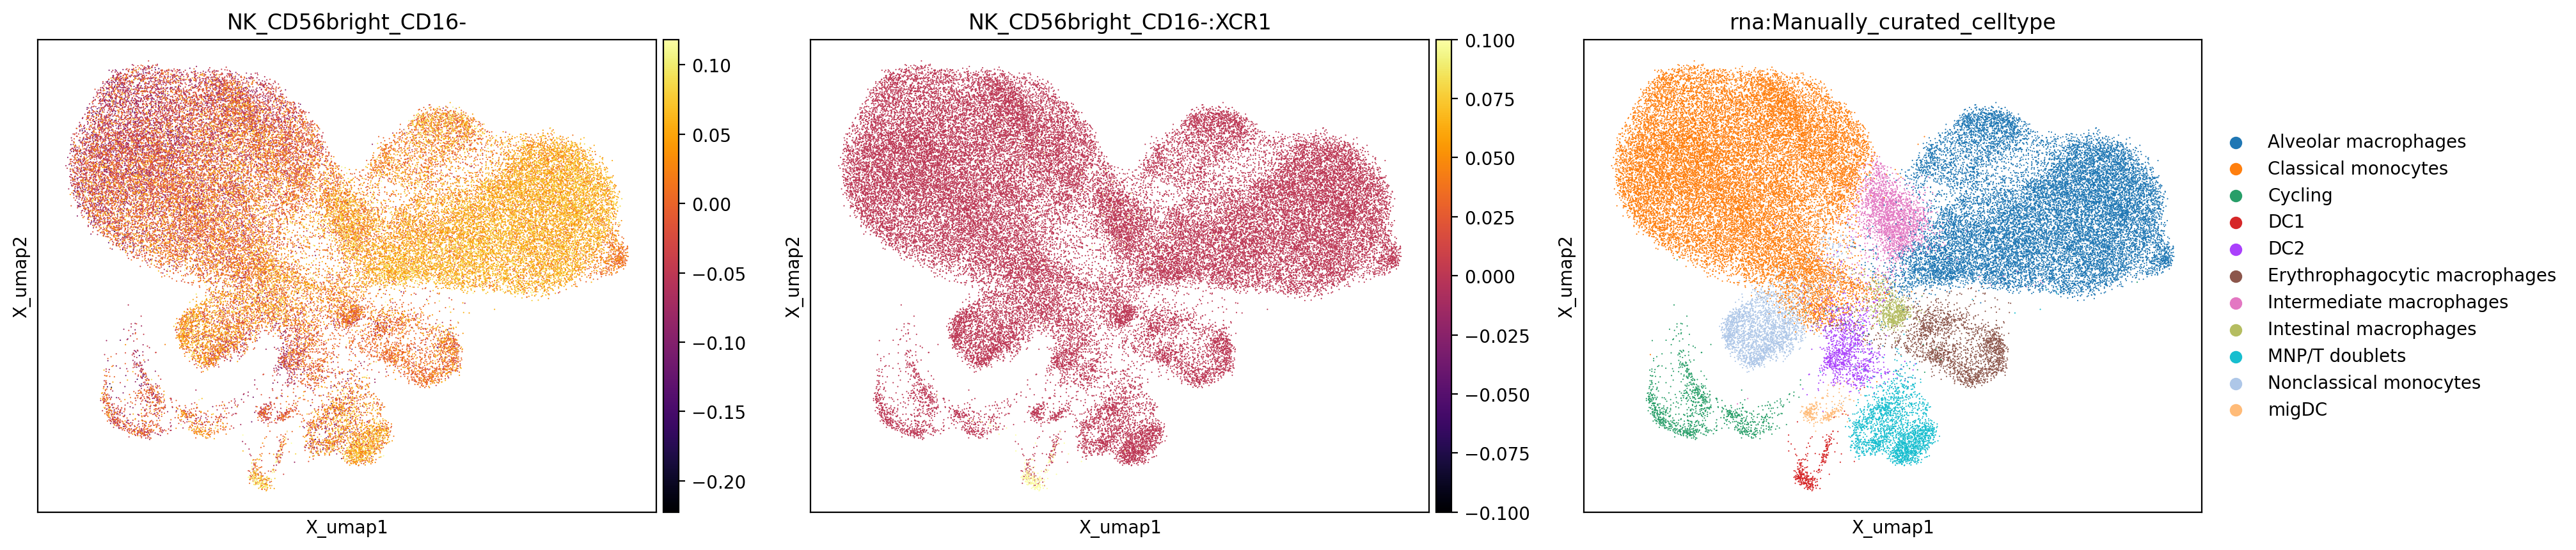

In [15]:
# Plot affinity of the myeloid cells towards NK_CD56bright_CD16-, and specific affinity through XCR1 
mu.pl.embedding(mdata, 
                basis="rna:X_umap", 
                color=["cell2home_affinity:NK_CD56bright_CD16-", "cell2home_target_affinity:NK_CD56bright_CD16-:XCR1", "rna:Manually_curated_celltype"], 
                cmap='inferno',
                vmax='p99'
               )

We find that NK_CD56bright_CD16- are predicted to attract Alveolar macrophages and DC1, and that affinity towards DC1 is mediated by XCR1

In [16]:
# Extract matrix for plotting clustered heatmap

A = mdata["cell2home_affinity"]                       # your AnnData
g = A.obs["Manually_curated_celltype"]

# group means (rows = groups, cols = populations in your order)
M = sc.get.obs_df(A, keys=list(populations)).assign(_g=g.values).groupby("_g").mean()[list(populations)]
if pd.api.types.is_categorical_dtype(g):      # keep the displayed row order
    M = M.reindex(g.cat.categories)

# standard_scale='var' → min–max per column
M_plot = ((M - M.min()) / (M.max() - M.min())).fillna(0.0)

In [17]:
# Prioritise strong signals for visualisation
M_plot_stronger = M_plot.pow(2.0)          # try 2–3; higher => harsher

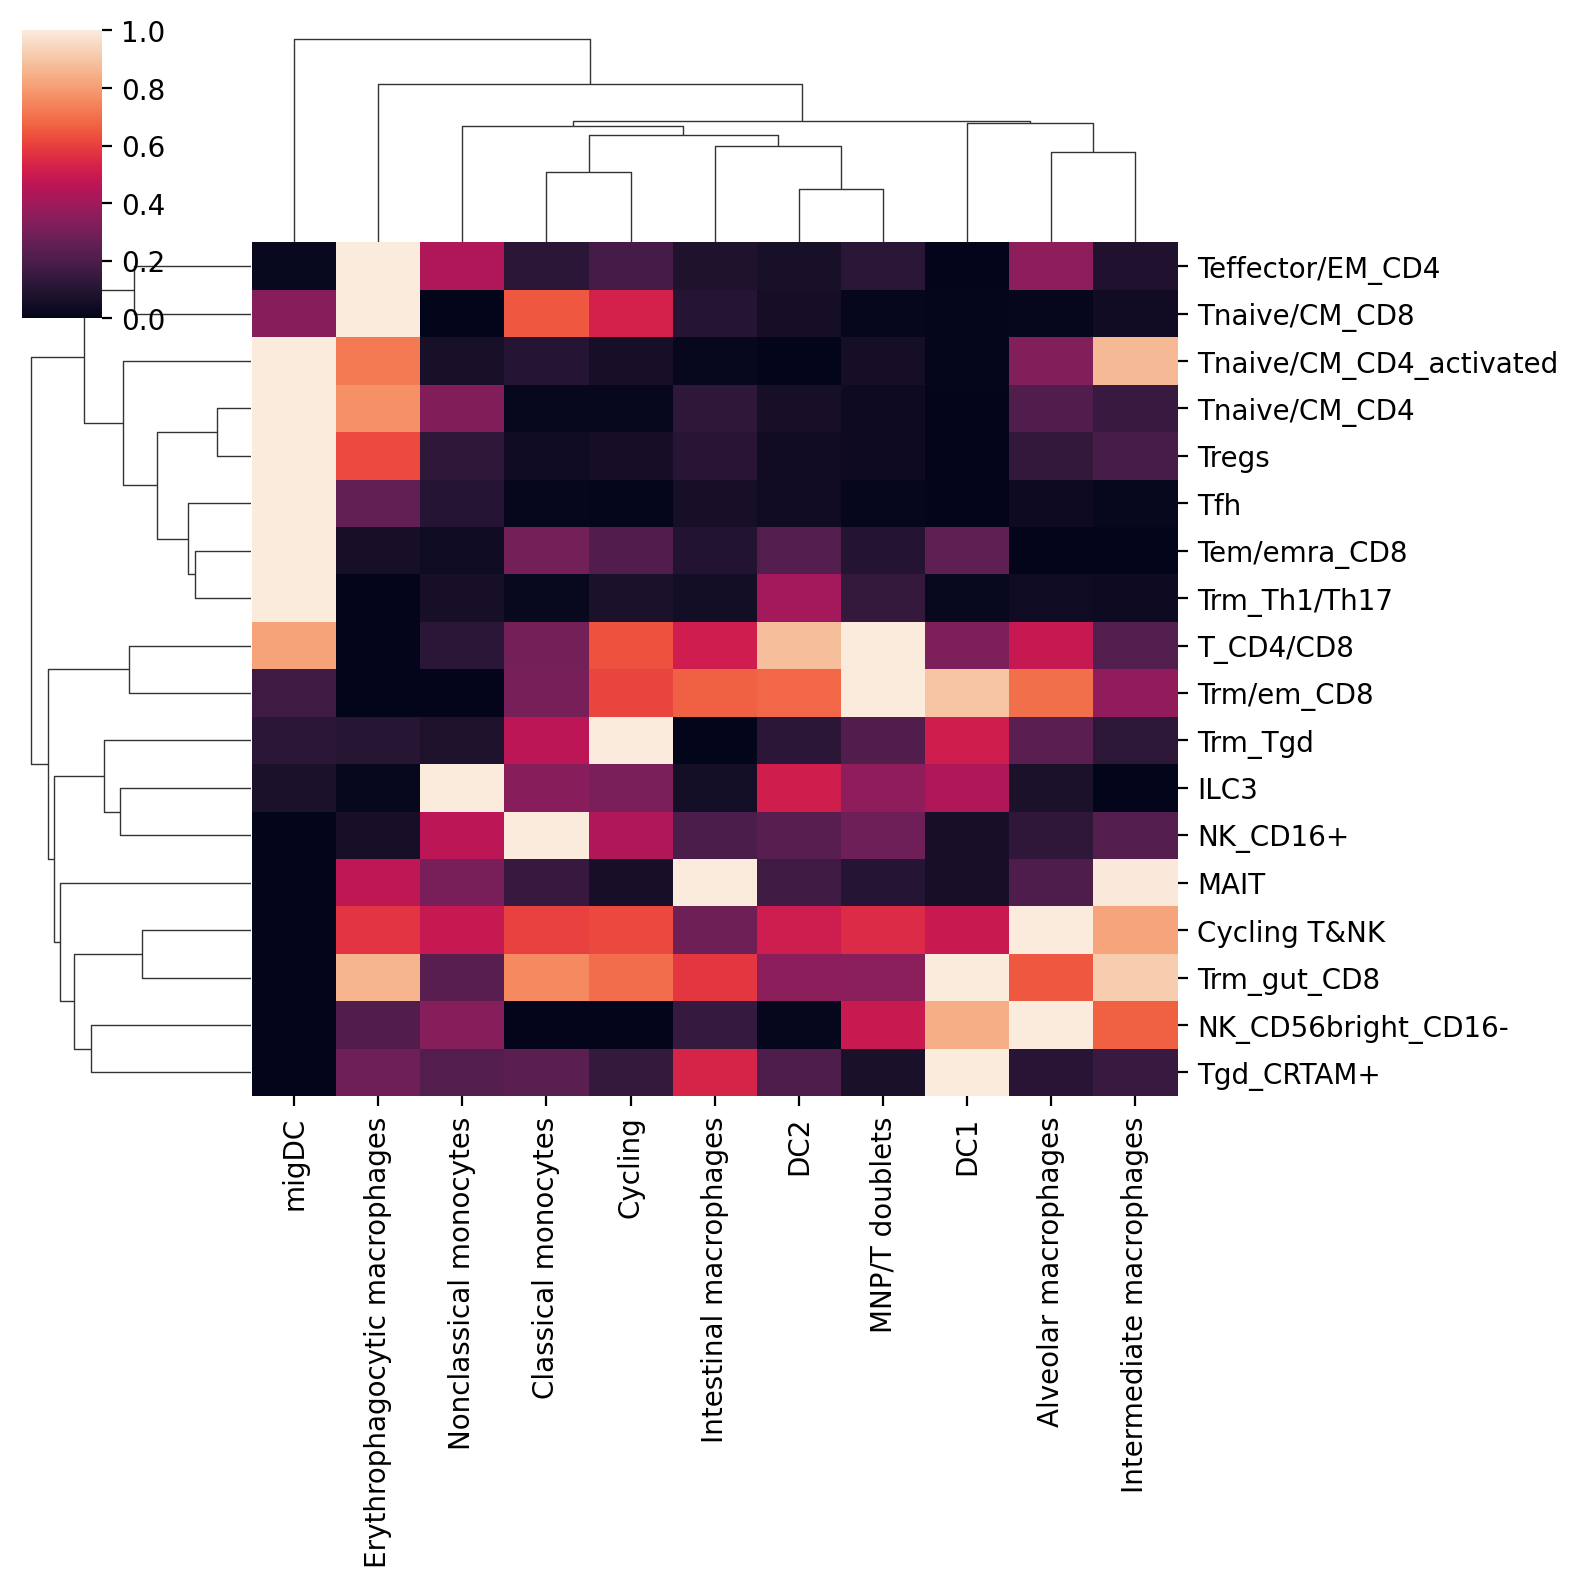

In [18]:
sns.clustermap(M_plot_stronger.T, col_cluster=True, row_cluster=True, figsize = (8,8))

In [19]:
# Find top interactions predicted to drive migration of a cell type to a target tissue/cell

top = c2h.compute_top_interactions_one_group(
    mdata,
    modality="cell_scores",
    identity="NK_CD56bright_CD16-",
    var_key="population",
    split_obs_key="Manually_curated_celltype",
    group_identity="DC1",
    top_n=10,
)
top

XCL1–XCR1       1.420306
XCL2–XCR1       1.277904
CXCL12–CXCR4    0.788314
ICAM1–ITGAL     0.479316
CXCL14–CXCR4    0.339726
ICAM3–ITGAL     0.285965
F11R–ITGAL      0.271622
CXCL9–CXCR3     0.181886
ICAM2–ITGAL     0.134578
CCL25–CCR9      0.023951
dtype: float32

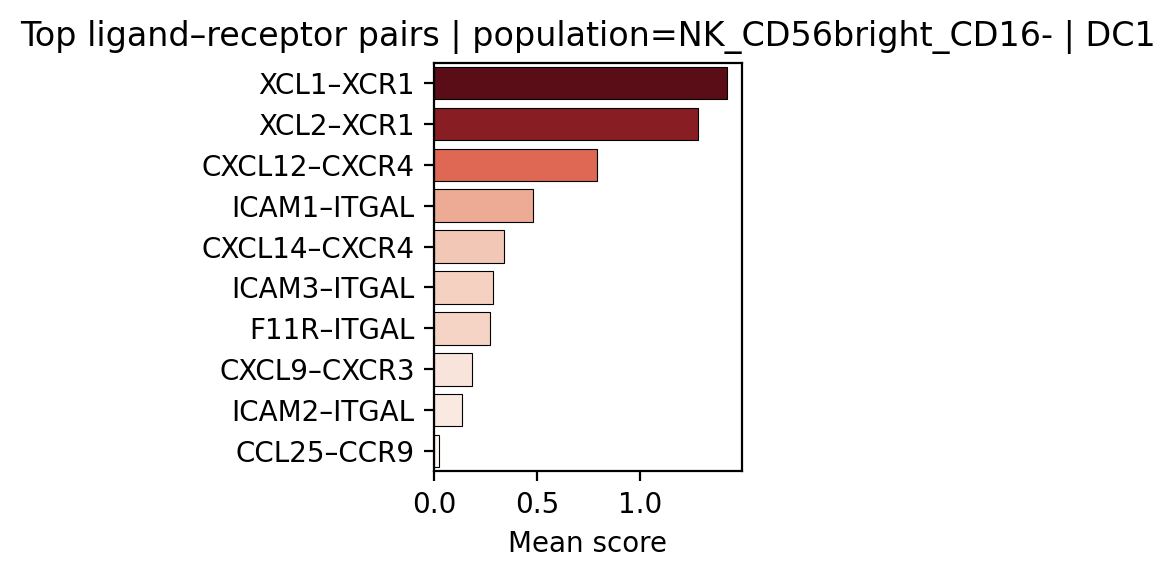

In [20]:
c2h.plot_top_interactions_bar_one_group(
    top,
    title="Top ligand–receptor pairs | population=NK_CD56bright_CD16- | DC1",
    cmap="Reds",
    figsize=(3,3)
)

In [21]:
# Save chemokine2cell object
import os
save_dir = "/lustre/scratch126/cellgen/teichmann/od5/projects/cell2home/demo/v0.0.1/"
os.makedirs(save_dir , exist_ok=True)
mdata.write((save_dir + "cell2home_demo.h5mu"))